In [1]:
import matplotlib.pyplot as plt
from helpers.cm26 import DatasetCM26, remesh
from helpers.computational_tools import select_NA, select_Pacific, StateFunctions, compare
from helpers.ann_tools import ANN, import_ANN, minibatch, export_ANN
import torch
import torch.optim as optim
import numpy as np
import xarray as xr
from time import time
import json
%load_ext autoreload
%autoreload 3

In [2]:
def sample_grid_harmonic(dataset, key, plain=False):
    '''
    Here for simplicity the dataset is coarsegrained
    snapshot of CM26.
    '''
    data = dataset.data
    ny, nx = data.u.shape
    
    u = np.zeros((ny,nx))
    v = np.zeros((ny,nx))
    
    # assign random phase (1 or -1)
    phase = -1 if np.random.randint(2)==0 else 1
    
    if key == 'vorticity':
        sign = -1
    elif key == 'divergence':
        sign = 1
    else:
        print('Error: key is wrongly specified')
    
    for j in range(ny):
        for i in range(nx):
            if plain:
                idx = i if np.random.randint(2)==0 else j
            else:
                idx = i+j
            u[j,i] = phase *        (-1)**(idx)
            v[j,i] = phase * sign * (-1)**(idx)
            
    data['u'] = xr.DataArray(u, dims=['yh', 'xq']) * dataset.param.wet_u
    data['v'] = xr.DataArray(v, dims=['yq', 'xh']) * dataset.param.wet_v
    return DatasetCM26(data, dataset.param, dataset.grid)

In [3]:
def sample_plane_wave(ny, nx):
        # Sampling frequency between -pi and pi, i.e. all
        # available frequencies
        freq_x = 0
        freq_y = 0
        while np.abs(freq_x)<2/3*np.pi and np.abs(freq_y)<2/3*np.pi:
            # i.e. if wave is inside the square of 2/3*pi,
            # keep sampling
            freq_x = np.random.rand() * np.pi * 2 - np.pi
            freq_y = np.random.rand() * np.pi * 2 - np.pi

        phase_u = np.random.rand()*2*np.pi
        phase_v = np.random.rand()*2*np.pi

        i = np.ones(ny).reshape(-1,1)@np.arange(nx).reshape(1,-1)
        j = np.arange(ny).reshape(-1,1)@np.ones(nx).reshape(1,-1)

        u = np.sin(freq_x * i + freq_y * j + phase_u)
        v = np.sin(freq_x * i + freq_y * j + phase_v)

        return u, v

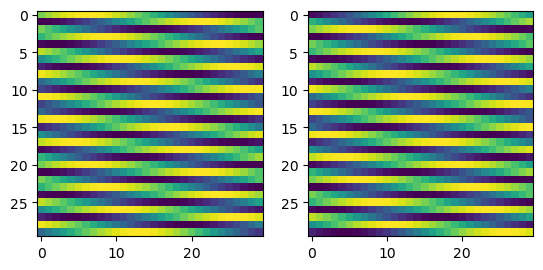

In [4]:
u, v = sample_plane_wave(30,30)
plt.subplot(1,2,1)
plt.imshow(u)
plt.subplot(1,2,2)
plt.imshow(v)

In [5]:
def sample_two_thirds(dataset):
    '''
    Here for simplicity the dataset is coarsegrained
    snapshot of CM26.
    '''        
    
    data = dataset.data
    ny, nx = data.u.shape
    u,v = sample_plane_wave(ny,nx)

    data['u'] = xr.DataArray(u, dims=['yh', 'xq']) * dataset.param.wet_u
    data['v'] = xr.DataArray(v, dims=['yq', 'xh']) * dataset.param.wet_v
    return DatasetCM26(data, dataset.param, dataset.grid)

In [6]:
ds = DatasetCM26()

In [7]:
training_dataset = ds.sample_epoch(time=np.random.randint(6950))

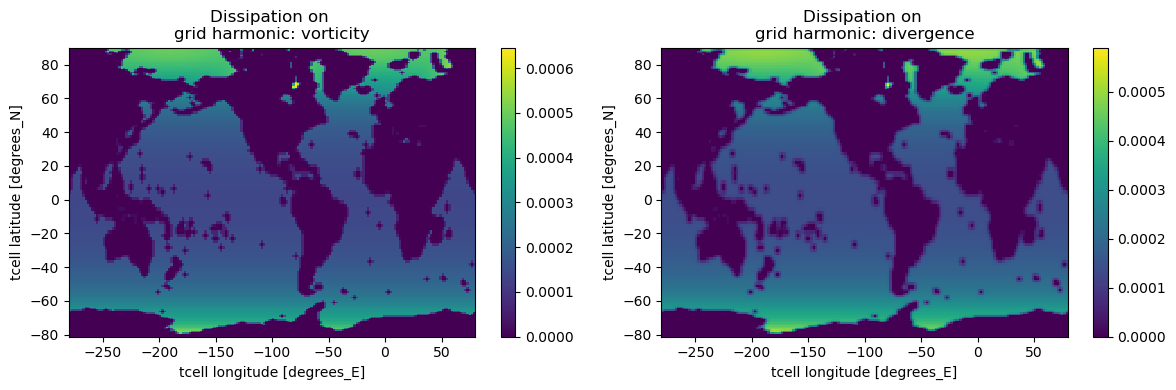

In [8]:
plt.figure(figsize=(12,4))
for j,grid_harmonic in enumerate(['vorticity', 'divergence']):
    batch = sample_grid_harmonic(training_dataset[20],grid_harmonic)
#    batch = sample_two_thirds(training_dataset[20])
    smag = batch.state.Smagorinsky()
    Txx = smag['Txx']
    Tyy = smag['Tyy']
    Txy = smag['Txy']
    sh_xy, sh_xx, vort_xy = batch.state.velocity_gradients()
    dissipation =  Txx * sh_xx + batch.grid.interp(Txy * sh_xy,['X','Y'])
    plt.subplot(1,2,1+j)
    dissipation.plot()
    plt.title(f'Dissipation on \ngrid harmonic: {grid_harmonic}')
plt.tight_layout()

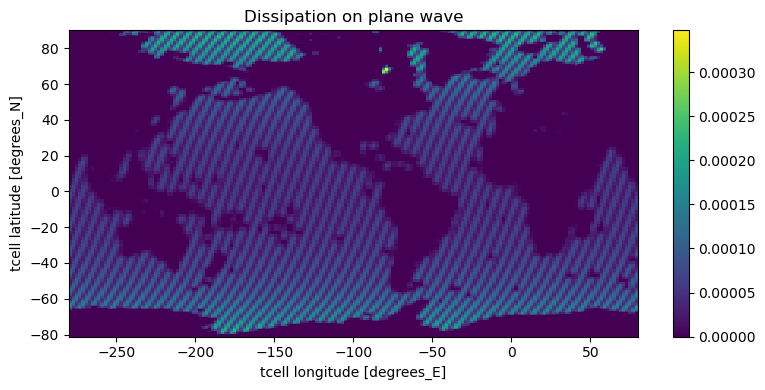

In [9]:
plt.figure(figsize=(8,4))
batch = sample_two_thirds(training_dataset[20])
smag = batch.state.Smagorinsky()
Txx = smag['Txx']
Tyy = smag['Tyy']
Txy = smag['Txy']
sh_xy, sh_xx, vort_xy = batch.state.velocity_gradients()
dissipation =  Txx * sh_xx + batch.grid.interp(Txy * sh_xy,['X','Y'])
dissipation.plot()
plt.title(f'Dissipation on plane wave')
plt.tight_layout()

In [16]:
ann_Txy = ANN([27, 20, 1])
ann_Txx_Tyy = ANN([27, 20, 2])
log_dict = {}
# ann_Txy = import_ANN('trained_models/ANN_CM26/Txy_epoch_2000.nc')
# ann_Txx_Tyy = import_ANN('trained_models/ANN_CM26/Txx_Tyy_epoch_2000.nc')

In [14]:
training_dataset = ds.sample_epoch(time=np.random.randint(6950)) # Approximately 19 years for training
batch = training_dataset[20]

In [17]:
num_epochs=500

all_parameters = list(ann_Txy.parameters()) + list(ann_Txx_Tyy.parameters())
optimizer = optim.Adam(all_parameters, lr=1e-3)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, 
        milestones=[int(num_epochs/2), int(num_epochs*3/4), int(num_epochs*7/8)], gamma=0.1)  

t_s = time()

for epoch in range(num_epochs):
    for ibatch in range(5):
        t_e = time()

        optimizer.zero_grad()
        ds_regularization = sample_two_thirds(batch)
        prediction = ds_regularization.state.Apply_ANN(ann_Txy, ann_Txx_Tyy)
        ANNxx = prediction['Txx']
        ANNyy = prediction['Tyy']
        ANNxy = prediction['Txy']
        smag = ds_regularization.state.Smagorinsky()
        Txx = torch.tensor(smag['Txx'].values).type(torch.float32)
        Tyy = torch.tensor(smag['Tyy'].values).type(torch.float32)
        Txy = torch.tensor(smag['Txy'].values).type(torch.float32)

        SGS_norm = 1. / torch.sqrt((Txx**2 + Tyy**2 + Txy**2).mean())

        MSE_plane_waves = (
            (ANNxx * SGS_norm - Txx * SGS_norm)**2 + \
            (ANNyy * SGS_norm - Tyy * SGS_norm)**2 + \
            (ANNxy * SGS_norm - Txy * SGS_norm)**2
        ).mean()
        del ds_regularization.data
        del ds_regularization.param

        loss = MSE_plane_waves

        loss.backward()
        optimizer.step()

    scheduler.step()    
    print(f'Epoch: {epoch}, MSE_plane_waves: {MSE_plane_waves}')

Epoch: 0, MSE_plane_waves: 9.098087310791016
Epoch: 1, MSE_plane_waves: 5.9653754234313965
Epoch: 2, MSE_plane_waves: 6.912248611450195
Epoch: 3, MSE_plane_waves: 3.5443975925445557
Epoch: 4, MSE_plane_waves: 3.936497926712036
Epoch: 5, MSE_plane_waves: 2.9889633655548096
Epoch: 6, MSE_plane_waves: 3.174353837966919
Epoch: 7, MSE_plane_waves: 3.0023508071899414
Epoch: 8, MSE_plane_waves: 0.4966614544391632
Epoch: 9, MSE_plane_waves: 1.426505446434021
Epoch: 10, MSE_plane_waves: 4.077734470367432
Epoch: 11, MSE_plane_waves: 1.9323662519454956
Epoch: 12, MSE_plane_waves: 1.2500211000442505
Epoch: 13, MSE_plane_waves: 0.7230972051620483
Epoch: 14, MSE_plane_waves: 1.981961965560913
Epoch: 15, MSE_plane_waves: 0.6943548321723938
Epoch: 16, MSE_plane_waves: 0.2666451632976532
Epoch: 17, MSE_plane_waves: 0.09740614145994186
Epoch: 18, MSE_plane_waves: 1.6717761754989624
Epoch: 19, MSE_plane_waves: 0.24136611819267273
Epoch: 20, MSE_plane_waves: 0.5863447189331055
Epoch: 21, MSE_plane_waves: 

# Check dissipation pattern for trained ANN

In [18]:
testing_dataset = ds.sample_epoch(time=np.random.randint(6950,8035))

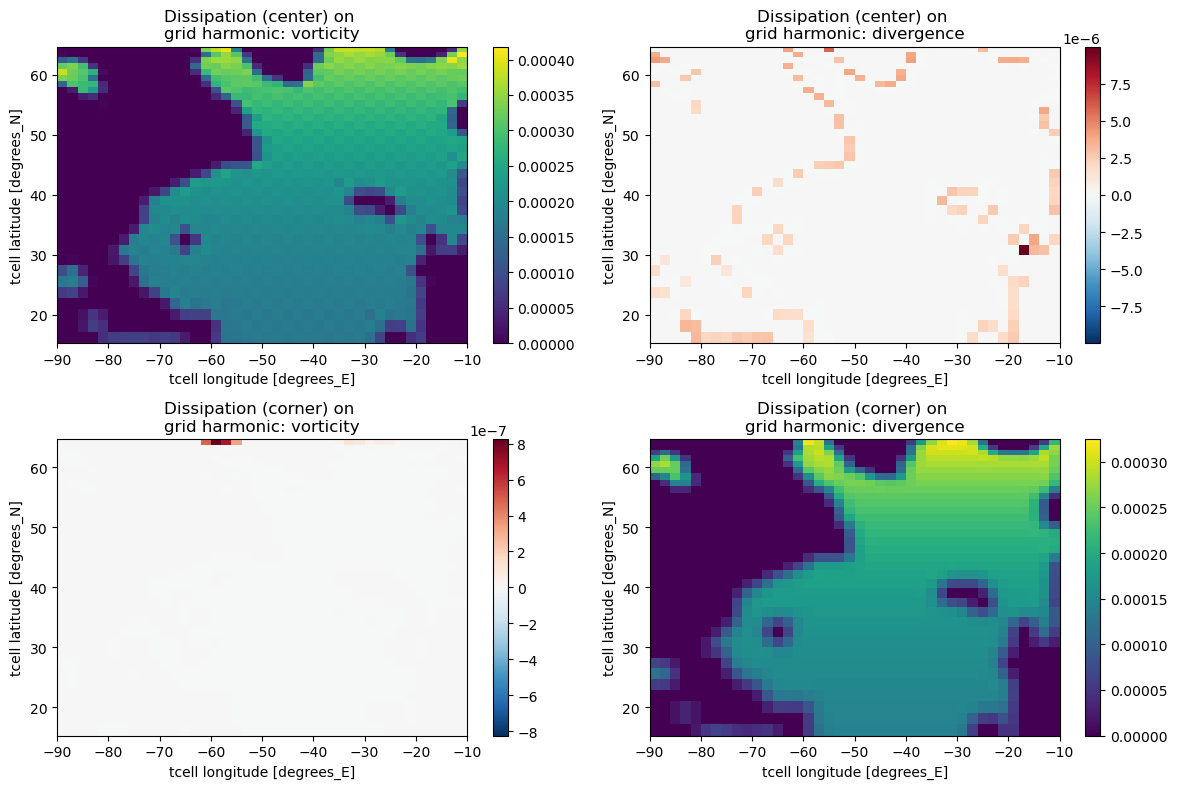

In [94]:
plt.figure(figsize=(12,8))
import cmocean
for j,grid_harmonic in enumerate(['vorticity', 'divergence']):
    batch = sample_grid_harmonic(testing_dataset[20],grid_harmonic,plain=False)
    zb = batch.state.ANN(ann_Txy, ann_Txx_Tyy)
#    zb = batch.state.Smagorinsky()
    plt.subplot(2,2,1+j)
    dissipation =  zb['Txx'] * zb['sh_xx']# + batch.grid.interp(zb['Txy'] * zb['sh_xy'],['X','Y'])
    select_NA(dissipation).plot()
    plt.title(f'Dissipation (center) on \ngrid harmonic: {grid_harmonic}')
    plt.subplot(2,2,3+j)
    dissipation =  batch.grid.interp(zb['Txy'] * zb['sh_xy'],['X','Y'])
    select_NA(dissipation).plot()
    plt.title(f'Dissipation (corner) on \ngrid harmonic: {grid_harmonic}')

plt.tight_layout()

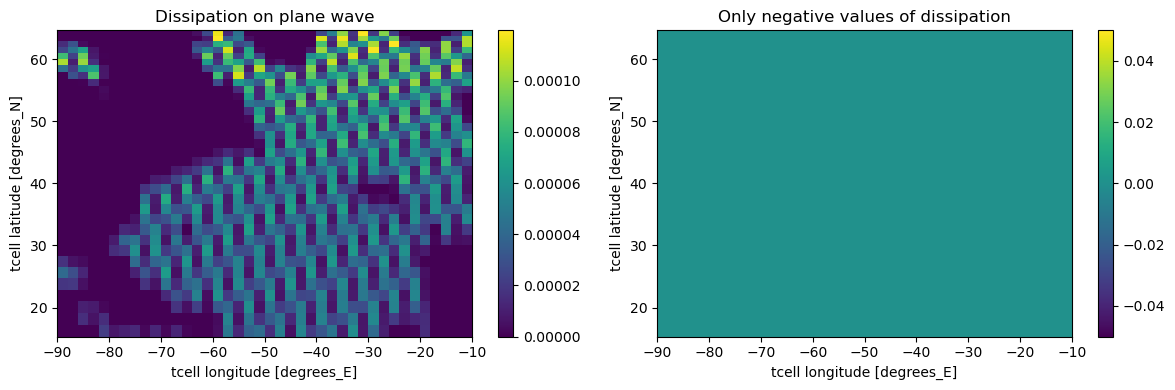

In [62]:
plt.figure(figsize=(12,4))
batch = sample_two_thirds(testing_dataset[20])
zb = batch.state.ANN(ann_Txy, ann_Txx_Tyy)
dissipation =  zb['Txx'] * zb['sh_xx'] + batch.grid.interp(zb['Txy'] * zb['sh_xy'],['X','Y'])
plt.subplot(1,2,1)
select_NA(dissipation).plot()
plt.title(f'Dissipation on plane wave')
plt.subplot(1,2,2)
select_NA(dissipation).plot(vmax=0)
plt.title('Only negative values of dissipation')
plt.tight_layout()

# Slight chess noise pattern is still present. Why?

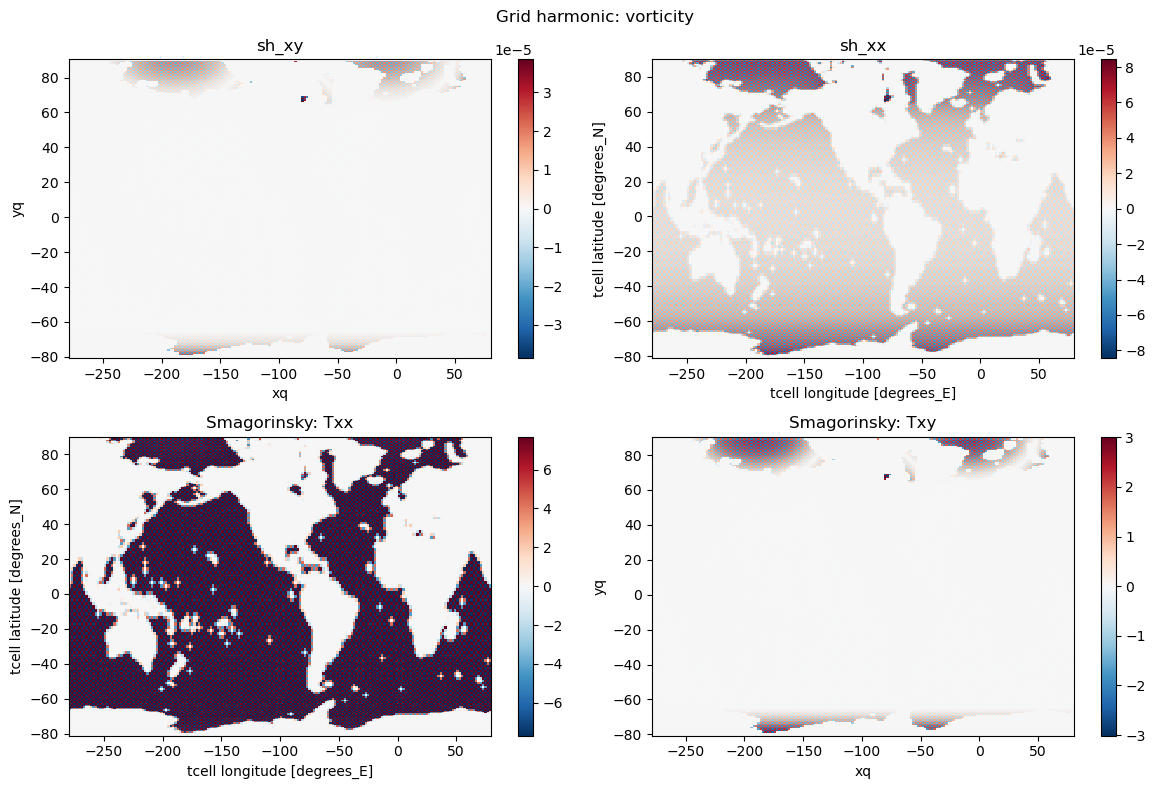

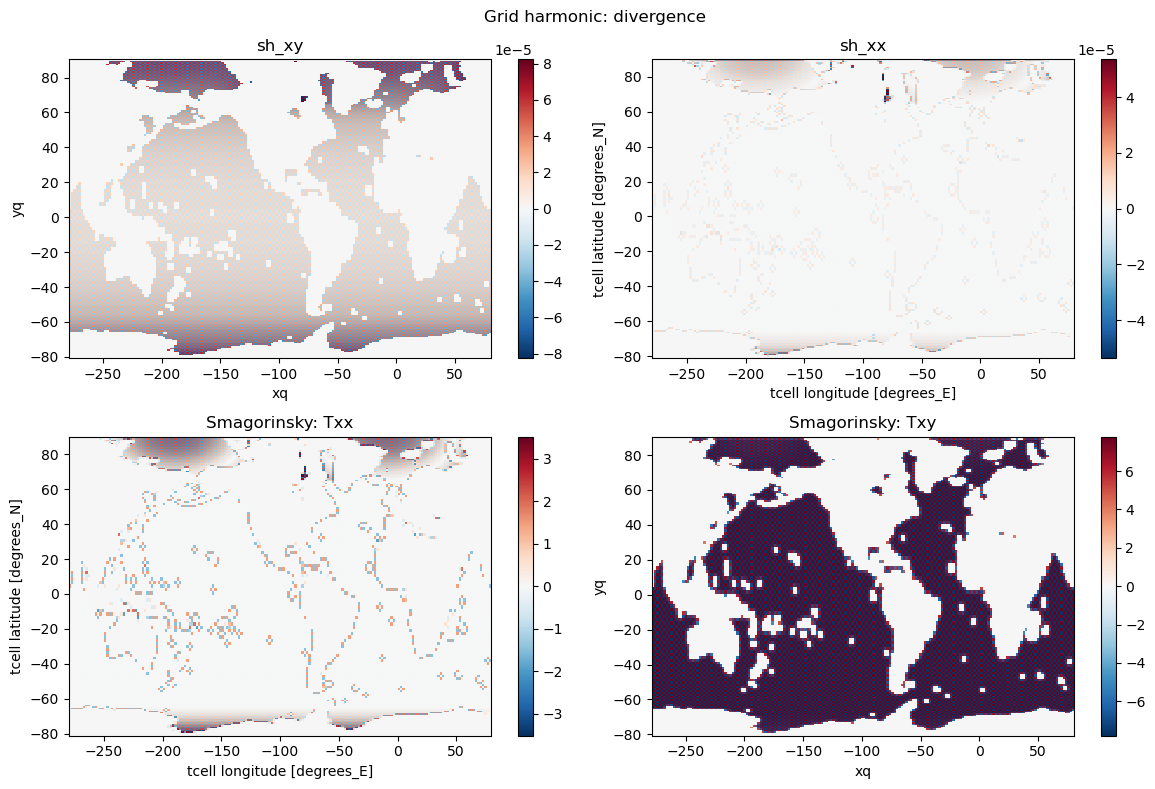

In [88]:
for grid_harmonic in ['vorticity', 'divergence']:
    batch = sample_grid_harmonic(testing_dataset[20],grid_harmonic,plain=False)
    sh_xy, sh_xx, vort_xy = batch.state.velocity_gradients()
    plt.figure(figsize=(12,8))
    plt.subplot(2,2,1)
    sh_xy.plot()
    plt.title('sh_xy')
    plt.suptitle(f'Grid harmonic: {grid_harmonic}')
    plt.subplot(2,2,2)
    sh_xx.plot()
    plt.title('sh_xx')
    smag = batch.state.Smagorinsky()
    plt.subplot(2,2,3)
    smag['Txx'].plot()
    plt.title('Smagorinsky: Txx')
    plt.subplot(2,2,4)
    smag['Txy'].plot()
    plt.title('Smagorinsky: Txy')
    plt.tight_layout()

# Conclusions: there is contribution from not collocated point for both vorticity and divergence harmonics. This contribution likely disappers due to involved interpolation which we use for input feeatures. Lack of this contribution in ANN as compared to Smagorinsky probably results to this effect. While this may be considered as important, we note that this effect is almost negligible after many epochs of training. Note that corner point is effectively less affected by staggering because smagorinsky coefficient is computed in center and only then interpolated.